# Business Case Discover


## Carga y Exploración Inicial
Cargar el dataset, visualizar las primeras filas y explorar la distribución de los datos con histogramas y diagramas de caja.
https://www.kaggle.com/datasets/yasserh/housing-prices-dataset

In [ ]:
# Importar librerías necesarias
import pandas as pd

# Cargar el dataset
data = '/data/Housing.csv'
df = pd.read_csv(data)

# Visualizar las primeras filas del dataset
print(df.head())

# Contar datos
print(df.count())

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  
price               545
area                545
bedrooms            545
bathrooms           545
sto

Comprobar valores nulos en cada columna

In [344]:
# Ver cuántos valores faltantes hay en cada columna
print(df.isnull().sum())

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


Manejo de valores faltantes y codificación de variables categóricas

In [345]:
# 1. Manejo de valores faltantes
from sklearn.impute import SimpleImputer

# Filtrar solo las columnas numéricas
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Imputar valores faltantes en las columnas numéricas con la mediana
imputer_num = SimpleImputer(strategy='median')
df[numeric_df.columns] = imputer_num.fit_transform(numeric_df)

# Imputar valores faltantes en las columnas categóricas con la moda
categorical_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                       'airconditioning', 'prefarea', 'furnishingstatus']

imputer_cat = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = imputer_cat.fit_transform(df[categorical_columns])

In [346]:
# 2. Codificación de variables categóricas
from sklearn.preprocessing import LabelEncoder

# 2.1 Convertir SOLO las variables binarias a (0/1)
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
label_encoder = LabelEncoder()

for col in binary_columns:
    df[col] = label_encoder.fit_transform(df[col])

# 2.2 Aplicamos pd.get_dummies() para 'furnishingstatus' (One-Hot Encoding)
df = pd.get_dummies(df, columns=['furnishingstatus']) # drop_first=True reduce la dimensionalidad y evita colinealidad en modelos lineales.

# 2.3 Convertir las nuevas columnas generadas por pd.get_dummies() (que son booleanas) a 0/1
# Esto se hace dinámicamente, ya que los nombres pueden variar según los valores únicos en 'furnishingstatus'
furnishing_columns = [col for col in df.columns if 'furnishingstatus' in col]

# 2.4 Convertimos las columnas que contienen 'furnishingstatus' de True/False a 0/1
df[furnishing_columns] = df[furnishing_columns].astype(int)

# Verificar el resultado final
print(df.head(10))

        price     area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  13300000.0   7420.0       4.0        2.0      3.0         1          0   
1  12250000.0   8960.0       4.0        4.0      4.0         1          0   
2  12250000.0   9960.0       3.0        2.0      2.0         1          0   
3  12215000.0   7500.0       4.0        2.0      2.0         1          0   
4  11410000.0   7420.0       4.0        1.0      2.0         1          1   
5  10850000.0   7500.0       3.0        3.0      1.0         1          0   
6  10150000.0   8580.0       4.0        3.0      4.0         1          0   
7  10150000.0  16200.0       5.0        3.0      2.0         1          0   
8   9870000.0   8100.0       4.0        1.0      2.0         1          1   
9   9800000.0   5750.0       3.0        2.0      4.0         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1      2.0         1   
1         0     

## Feature Engineering


### Crear datos sinteticos


In [347]:
import pandas as pd
import numpy as np

def generar_datos_sinteticos(df, n, noise_level=0.05):
    df_synth = df.copy()

    # Seleccionamos columnas numéricas (puedes ajustar esto según necesidad)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Creamos n muestras aleatorias del dataset original
    df_sample = df.sample(n=n, replace=True).reset_index(drop=True)

    # Agregamos ruido
    for col in numeric_cols:
        std = df[col].std()
        noise = np.random.normal(0, noise_level * std, size=n)
        df_sample[col] += noise

    # Aseguramos que los enteros no pierdan su tipo
    for col in df.columns:
        if 'int' in str(df[col].dtype):
            df_sample[col] = df_sample[col].round().astype(int)

    return df_sample

df_sintetico = generar_datos_sinteticos(df, n=1500)
df = pd.concat([df, df_sintetico], ignore_index=True)

Contar cantidad de datos por columnas

In [348]:
df.count()

,0
price,2045
area,2045
bedrooms,2045
bathrooms,2045
stories,2045
mainroad,2045
guestroom,2045
basement,2045
hotwaterheating,2045
airconditioning,2045


### Creación de KPIs

Creamos más columnas a partir de los datos existentes

In [349]:
# Copiar el DataFrame original para no modificar el original
df_featured = df.copy()

# Total de habitaciones (habitaciones + baños)
df_featured['total_rooms'] = df_featured['bedrooms'] + df_featured['bathrooms']

# *Precio por área* (precio por metro cuadrado)
df_featured["price_per_sqft"] = df_featured["price"] / df_featured["area"]

# *Precio* por habitación (precio dividido entre el número total de habitaciones)
df_featured['price_per_room'] = df_featured['price'] / df_featured['total_rooms']

# Área por habitación (área dividida entre el número total de habitaciones)
df_featured['area_per_room'] = df_featured['area'] / df_featured['total_rooms']

# Número de habitaciones por área (habitaciones divididas entre área)
df_featured['bedrooms_per_area'] = df_featured['bedrooms'] / df_featured['area']

# Número de baños por área (baños divididos entre área)
df_featured['bathrooms_per_area'] = df_featured['bathrooms'] / df_featured['area']

# Relación entre el número de baños y el número de habitaciones
df_featured['bedrooms_bathrooms_ratio'] = df_featured['bedrooms'] / df_featured['bathrooms']

# Ratio de baños por habitación
df_featured['bathrooms_per_bedroom'] = df_featured['bathrooms'] / df_featured['bedrooms']

# Habitaciones por planta
df_featured['bedrooms_per_story'] = df_featured['bedrooms'] * df_featured['stories']

# Baños por planta
df_featured['bathroom_stories'] = df_featured['bathrooms'] * df_featured['stories']

# Puntuación de calidad
df_featured['quality_score'] = (
        df_featured['airconditioning'] * 3 +
        df_featured['basement'] * 2 +
        df_featured['guestroom'] * 1.5 +
        df_featured['hotwaterheating'] * 2.5 +
        df_featured['prefarea'] * 3
    )

# Puntuación de conveniencia
df_featured['convenience_score'] = (
    df_featured['mainroad'] * 2 +
    df_featured['parking'] * 1.5 +
    df_featured['prefarea'] * 2
)

# Puntuación de confort
df_featured['comfort_score'] = (
    df_featured['airconditioning'] * 2 +
    df_featured['hotwaterheating'] * 1.5 +
    df_featured['basement'] * 2
)

# Puntuación de amueblado
df_featured['furnishing_score'] = (
    df_featured['furnishingstatus_furnished'] * 3 +
    df_featured['furnishingstatus_semi-furnished'] * 2 +
    df_featured['furnishingstatus_unfurnished'] * 1  # 1 para unfurnished, 2 para semi-furnished
)

# Puntuación de accesibilidad
df_featured['accessibility_score'] = (
    df_featured['mainroad'] * 2 +
    df_featured['area'] / 1000 +
    df_featured['stories'] * 1.5
)

# Puntuación de eficiencia en la distribución de espacios
df_featured['space_efficiency_score'] = (
    df_featured['area'] / (df_featured['bedrooms'] + df_featured['bathrooms']) * 1.5 +
    df_featured['stories'] * 1
)

# Puntuación de lujosidad
df_featured['luxury_score'] = df_featured['quality_score'] * df_featured['convenience_score']
df_featured['quality_per_room'] = df_featured['quality_score'] / df_featured['total_rooms']
df_featured['luxury_per_area'] = df_featured['luxury_score'] / df_featured['area'] * 1000

# Puntuación de exclusividad
df_featured['exclusivity_score'] = (
    df_featured['prefarea'] * 3 +
    df_featured['mainroad'] * 1
)


# Mostrar el DataFrame con los nuevos KPIs
print(df_featured.head())
df = pd.concat([df, df_featured], ignore_index=True)

        price    area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  13300000.0  7420.0       4.0        2.0      3.0         1          0   
1  12250000.0  8960.0       4.0        4.0      4.0         1          0   
2  12250000.0  9960.0       3.0        2.0      2.0         1          0   
3  12215000.0  7500.0       4.0        2.0      2.0         1          0   
4  11410000.0  7420.0       4.0        1.0      2.0         1          1   

   basement  hotwaterheating  airconditioning  ...  quality_score  \
0         0                0                1  ...            6.0   
1         0                0                1  ...            3.0   
2         1                0                0  ...            5.0   
3         1                0                1  ...            8.0   
4         1                0                1  ...            6.5   

   convenience_score  comfort_score  furnishing_score  accessibility_score  \
0                7.0            2.0               

In [350]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4090 entries, 0 to 4089
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   price                            4090 non-null   float64
 1   area                             4090 non-null   float64
 2   bedrooms                         4090 non-null   float64
 3   bathrooms                        4090 non-null   float64
 4   stories                          4090 non-null   float64
 5   mainroad                         4090 non-null   int64  
 6   guestroom                        4090 non-null   int64  
 7   basement                         4090 non-null   int64  
 8   hotwaterheating                  4090 non-null   int64  
 9   airconditioning                  4090 non-null   int64  
 10  parking                          4090 non-null   float64
 11  prefarea                         4090 non-null   int64  
 12  furnishingstatus_fur

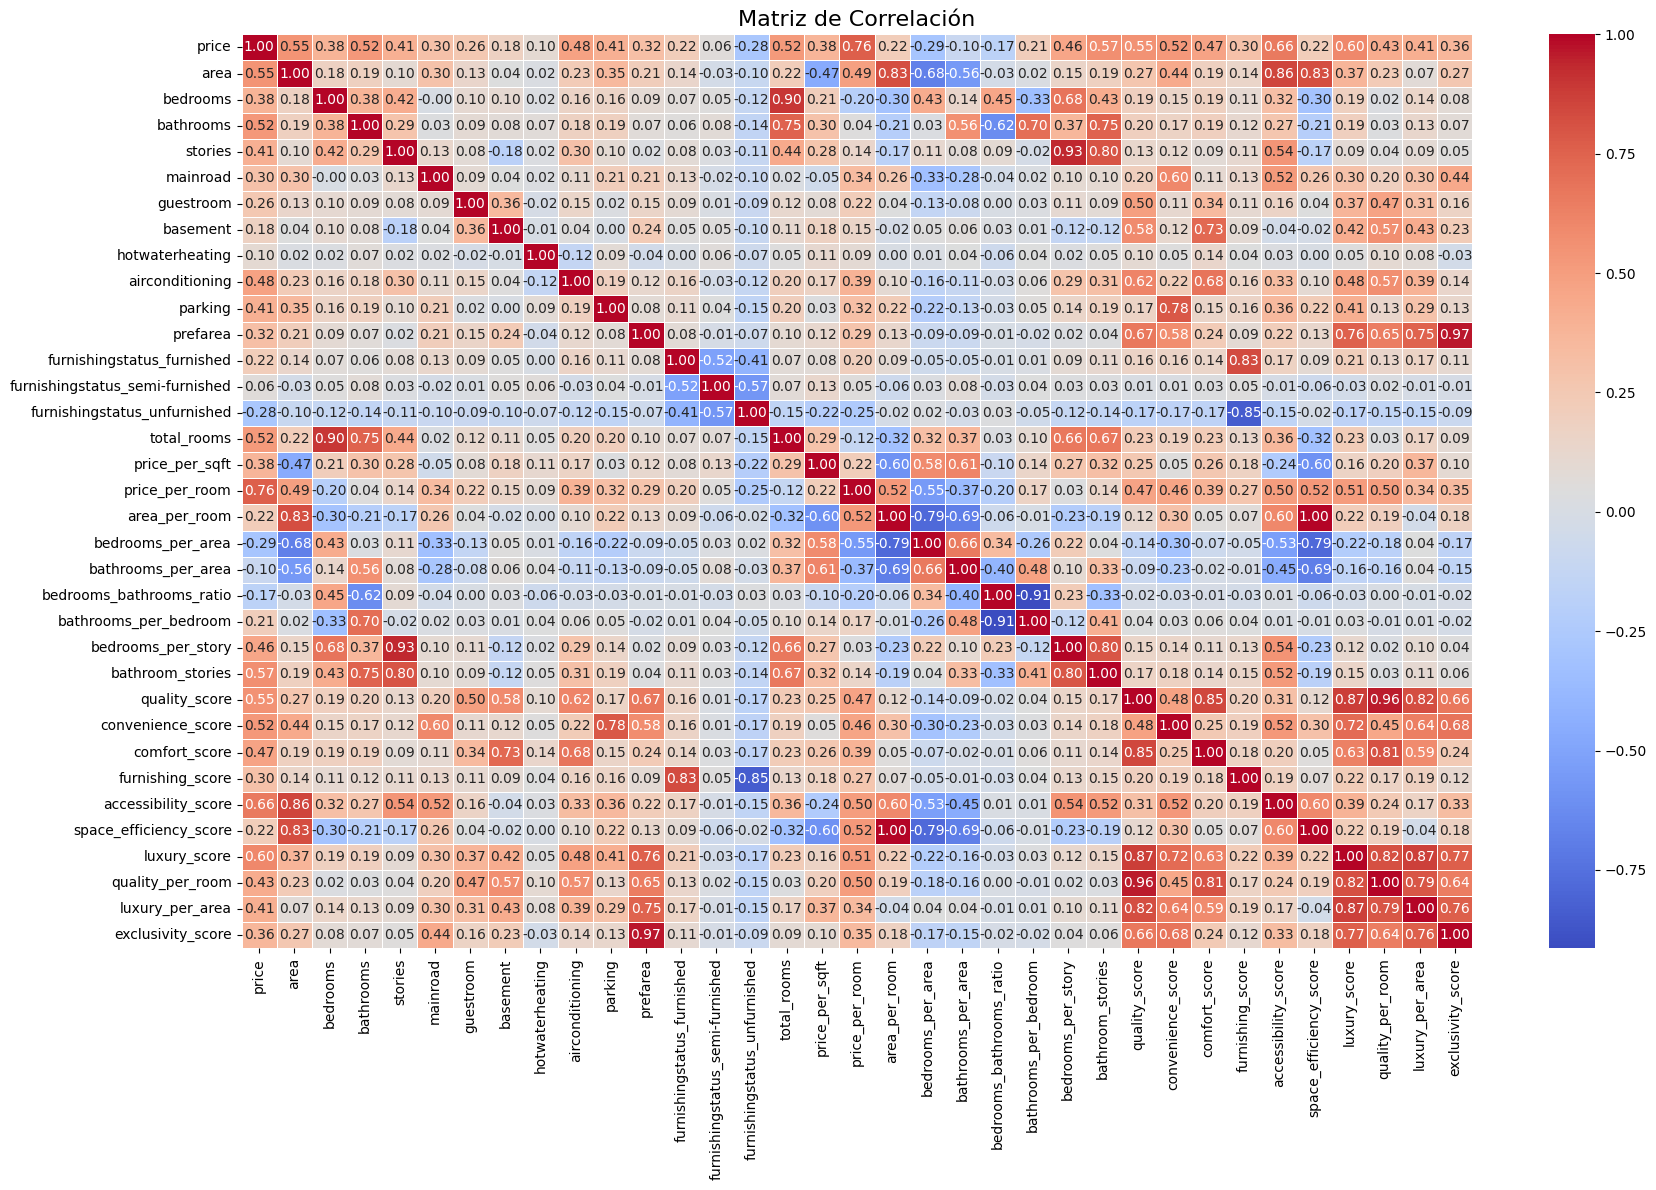


Correlación con la variable objetivo 'price':
price                              1.000000
price_per_room                     0.761715
accessibility_score                0.656427
luxury_score                       0.596230
bathroom_stories                   0.568230
quality_score                      0.552293
area                               0.545227
convenience_score                  0.522257
bathrooms                          0.521864
total_rooms                        0.521317
airconditioning                    0.477494
comfort_score                      0.472922
bedrooms_per_story                 0.455152
quality_per_room                   0.431639
luxury_per_area                    0.409363
stories                            0.408946
parking                            0.408317
bedrooms                           0.379675
price_per_sqft                     0.377981
exclusivity_score                  0.364507
prefarea                           0.315876
furnishing_score             

In [351]:
# Importar librerías necesarias
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la matriz de correlación
correlation_matrix = df_featured.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación", fontsize=16)
plt.tight_layout()
plt.show()

# Correlación con la variable objetivo 'price'
correlation_with_price = correlation_matrix['price'].sort_values(ascending=False)
print("\nCorrelación con la variable objetivo 'price':")
print(correlation_with_price)

In [352]:
print(df_featured.drop(columns=['price', 'price_per_room', 'price_per_sqft']))

              area  bedrooms  bathrooms   stories  mainroad  guestroom  \
0      7420.000000  4.000000   2.000000  3.000000         1          0   
1      8960.000000  4.000000   4.000000  4.000000         1          0   
2      9960.000000  3.000000   2.000000  2.000000         1          0   
3      7500.000000  4.000000   2.000000  2.000000         1          0   
4      7420.000000  4.000000   1.000000  2.000000         1          1   
...            ...       ...        ...       ...       ...        ...   
2040  10268.180760  1.986946   0.980570  1.005403         1          0   
2041   8313.848258  4.025037   1.010626  4.044544         1          0   
2042   2197.896379  3.047364   2.011638  1.890427         0          0   
2043   4833.608127  3.941558   0.992165  3.050757         0          0   
2044   5005.921654  4.000794   0.976054  3.048152         0          0   

      basement  hotwaterheating  airconditioning   parking  ...  \
0            0                0             

In [353]:
print(np.log1p(df_featured['price']))

0       16.403275
1       16.321037
2       16.321037
3       16.318175
4       16.250001
          ...    
2040    15.350547
2041    15.350850
2042    15.051060
2043    15.059700
2044    15.045447
Name: price, Length: 2045, dtype: float64


In [354]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import numpy as np
import joblib

# Normalizar la variable objetivo (log transform)
y_log = np.log1p(df_featured['price'])

# Definir las características (X) y la variable objetivo (y)
X = df_featured.drop(columns=['price', 'price_per_room', 'price_per_sqft'])
y = y_log
# y = df.featured['price']

# Dividir el dataset en conjunto de entrenamiento y conjunto de prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Declaramos el Scalar que usaremos
scaler = MinMaxScaler()

# Guardar el scaler de X, el mismo para y
joblib.dump(scaler, "scaler.joblib")

# Normalizar las características (X) con RobustScaler o MinMaxScaler
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Normalizar la variable objetivo (y) con RobustScaler o MinMaxScaler
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))

# Verificar las dimensiones de los conjuntos de entrenamiento y prueba
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")


Dimensiones de X_train: (1636, 32)
Dimensiones de X_test: (409, 32)
Dimensiones de y_train: (1636, 1)
Dimensiones de y_test: (409, 1)


In [355]:
print(X_train, X_test)

[[0.4356927  0.40922205 0.02153207 ... 0.68010535 0.19584303 0.25      ]
 [0.13573933 0.21648837 0.02604639 ... 0.         0.01265181 0.25      ]
 [0.50028849 0.60549414 0.35770928 ... 0.51738028 0.30972935 1.        ]
 ...
 [0.20697664 0.41123451 0.02466494 ... 0.36436967 0.11051992 0.25      ]
 [0.23527518 0.41157861 0.03150463 ... 0.         0.01265181 0.25      ]
 [0.14468811 0.21578537 0.02696761 ... 0.48526901 0.14662494 0.25      ]] [[0.12552295 0.41148106 0.02604639 ... 0.         0.01265181 0.25      ]
 [0.10433218 0.40004082 0.0277569  ... 0.31609746 0.24112799 0.25      ]
 [0.27468212 0.21648837 0.02604639 ... 0.         0.01265181 0.        ]
 ...
 [0.15422453 0.2006746  0.03013186 ... 0.         0.01265181 0.25      ]
 [0.33275029 0.40433786 0.02463531 ... 0.84030488 0.33811814 1.        ]
 [0.32118325 0.41504655 0.00224787 ... 0.5271637  0.19419349 0.25      ]]


## Creación del modelo

*   Construcción del modelo
*   Definción de parámetros



In [356]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import MeanSquaredError

# Función para construir el modelo
#def build_model(input_shape, learning_rate=0.001, l2_reg=0.01, dropout=0.02):
def build_model(input_shape):
    model = Sequential([
        # Capa de entrada - Usar Input en lugar de input_shape en la primera capa
        Input(shape=(input_shape,)),  # Aquí se define la forma de entrada
        Dense(35, activation='relu'),
        Dropout(0.2),

        # Capa oculta 1
        Dense(64, activation='relu'),
        Dropout(0.1),

        # Capa oculta 2
        Dense(32, activation='relu'),
        Dropout(0.1),

        # Capa oculta 3
        Dense(16, activation='relu'),
        Dropout(0.1),

        # Capa de salida
        Dense(1, activation='linear')  # Capa final para regresión (una sola neurona sin activación)
    ])

    # Compilación del modelo con optimizador Adam y función de pérdida MSE
    model.compile(
        optimizer=Adam(),
        loss='mean_squared_error',
        metrics=[MeanSquaredError()]
    )

    return model


In [357]:
# Definir el modelo con los parámetros deseados
# model = build_model(input_shape=X_train.shape[1], learning_rate=0.005, l2_reg=0.01)

# Asumiendo que X_train.shape[1] es el número de características (columnas) de tus datos
input_shape = X_train.shape[1]

# Llamamos a la función build_model pasando el número de características como input_shape
model = build_model(input_shape)

# Mostramos el resumen del modelo
model.summary()


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_80 (Dense)                     │ (None, 35)                  │           1,155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 35)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 64)                  │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,084 (23.77 KB)

 Trainable params: 6,084 (23.77 KB)

 Non-trainable params: 0 (0.00 B)

In [358]:
from tensorflow.keras.callbacks import EarlyStopping

# Usar early stopping para evitar el sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entrenamiento del modelo
history = model.fit(X_train, y_train,
                    epochs=300,  # Número de épocas, puedes ajustarlo
                    batch_size=32,  # Tamaño del batch, puedes ajustarlo
                    validation_data=(X_test, y_test),  # Usamos los datos de test para la validación
                    callbacks=[early_stopping],  # Usamos el callback de EarlyStopping
                    verbose=1)  # Muestra el progreso del entrenamiento


Epoch 1/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1021 - mean_squared_error: 0.1021 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 2/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 3/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0257 - mean_squared_error: 0.0257 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 4/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 5/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 6/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 7/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0094 - va

- early_stopping: Usamos la técnica de early stopping para detener el entrenamiento si no hay mejora en la pérdida de validación, evitando así el sobreajuste.

- monitor='val_loss': Se está monitoreando la pérdida de validación (val_loss). Si esta no mejora después de cierto número de épocas, el entrenamiento se detiene.

- patience=20: Este parámetro indica cuántas épocas esperar antes de detener el entrenamiento si no hay mejora en la pérdida de validación. En este caso, se detendrá después de 20 épocas sin mejora.

- restore_best_weights=True: Cuando se detiene el entrenamiento, se restauran los pesos del modelo de la mejor época (es decir, la época con la menor pérdida de validación).

- Entrenamiento del modelo: El entrenamiento se realiza con el número de épocas y el tamaño del batch que especifiques, utilizando los datos de validación y el callback para evitar el sobreajuste.

## Evaluación del modelo


In [359]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluación del modelo en el conjunto de prueba
y_pred = model.predict(X_test)

# Métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calcula el RMSE
rmse = np.sqrt(mse) #np.sqrt(np.mean((y_test - y_pred) ** 2))

# Calcula el valor promedio de los precios reales de test
avg_price = np.mean(y_test)

# Calcula el porcentaje de error
rmsr_porcentage = (rmse / avg_price) * 100

print("MAE:", mae)
print("MSE:", mse)
print(f"RMSE: {rmsr_porcentage:.2f}%")
print(f"R²: {r2:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MAE: 0.045716226789722245
MSE: 0.003910474337545278
RMSE: 12.98%
R²: 0.87%


### Métricas

- MAE (Error Absoluto Medio):

El MAE mide el promedio de los errores absolutos entre las predicciones y los valores reales. Es una métrica que indica qué tan cerca están las predicciones de los valores reales en promedio. Un MAE más bajo indica un mejor ajuste del modelo.

- MSE (Error Cuadrático Medio):

El MSE es el promedio de los errores cuadráticos, es decir, la diferencia al cuadrado entre las predicciones y los valores reales. Al elevar al cuadrado los errores, el MSE penaliza más los errores grandes, lo que puede ser útil si se desea minimizar la influencia de valores atípicos.

- RMSE (Raíz del Error Cuadrático Medio):

El RMSE es la raíz cuadrada del MSE. Al tomar la raíz cuadrada, se obtiene una métrica que está en la misma unidad que los valores originales, lo que facilita su interpretación. Al igual que el MSE, el RMSE penaliza más los errores grandes.

- R² (Coeficiente de Determinación):

El R² indica la proporción de la varianza en los datos que es explicada por el modelo. Un valor de R² cercano a 1 indica que el modelo explica bien los datos, mientras que un valor cercano a 0 indica que el modelo no explica bien los datos. Es una métrica útil para evaluar la bondad del ajuste del modelo.

In [360]:
# Convertir y_test y y_pred a arrays de numpy
# y_pred_reshaped = np.array(y_pred).reshape(-1, 1)  # Convertir y_pred a 2D si no lo está ya
# y_pred_original = scaler_y.inverse_transform(y_pred_reshaped)  # Desnormalizar las predicciones

# y_test_reshaped = np.array(y_test).reshape(-1, 1)  # Convertir y_test a 2D si no lo está ya
# y_test_original = scaler_y.inverse_transform(y_test_reshaped)  # Desnormalizar los valores reales

# Calcular el MSE, RMSE y R2 en la escala original
# mse = mean_squared_error(y_test_original, y_pred_original)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test_original, y_pred_original)

# Calcular el porcentaje de RMSE
# avg_y = np.mean(y_test_original)
# rmse_percentage = (rmse / avg_y) * 100

# Mostrar los resultados
# print(f"Test MSE (desnormalizado): {mse}")
# print(f"Test RMSE (desnormalizado): {rmse}")
# print(f"Test R2 (desnormalizado): {r2}")
# print(f"Test RMSE Percentage: {rmse_percentage}%")

### Guardar el modelo

In [367]:
# Guardar el modelo
model.save("prediccion_precio_casas.keras")

## Análisis y Resultados

### Gráficos de error

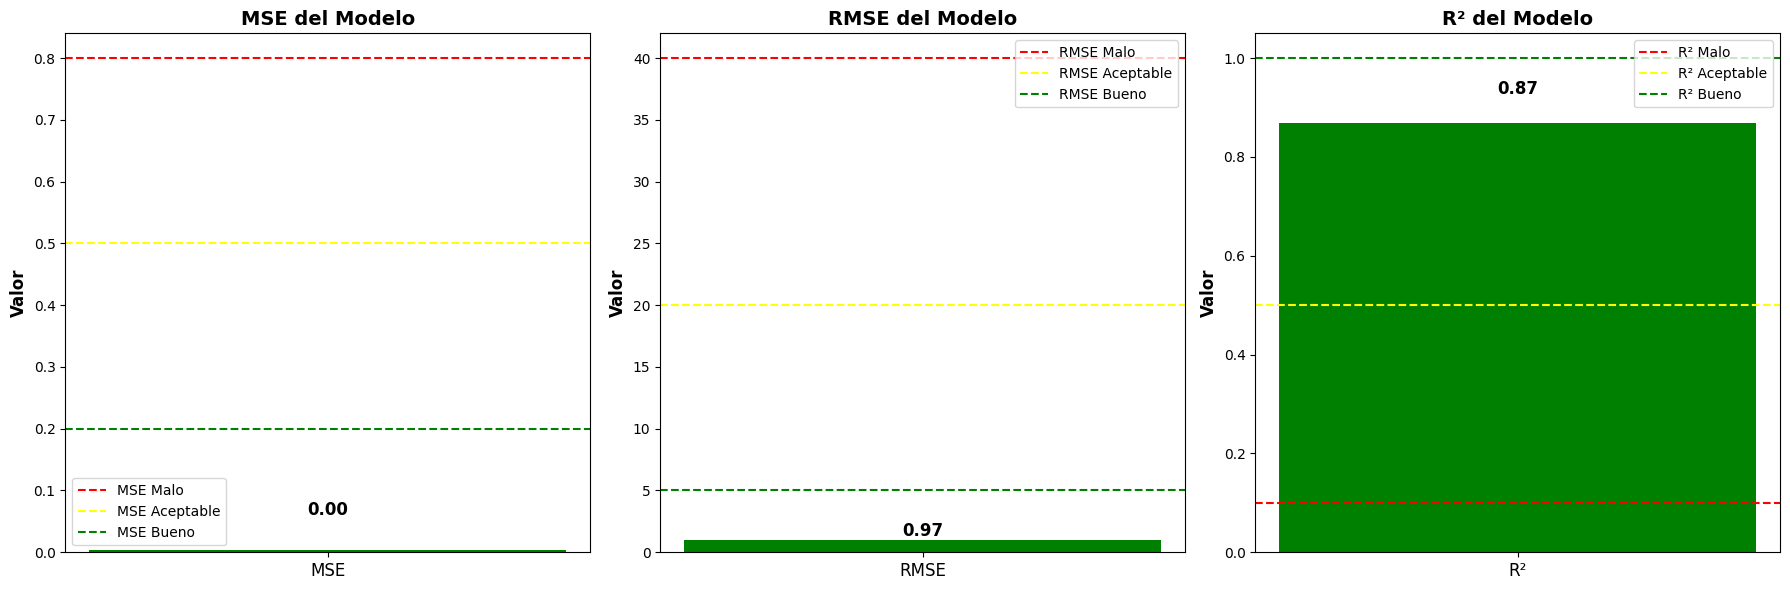

In [362]:
import matplotlib.pyplot as plt

# Definir las métricas
metrics = {'MSE': mse, 'RMSE': rmse_percentage, 'R²': r2}

# Definir los rangos para cada métrica (Malo, Aceptable, Bueno)
ranges = {
    'MSE': {'min': 0.8, 'acceptable': 0.5, 'max': 0.2},  # Ejemplo: MAE malo > 0.8, aceptable entre 0.5 y 0.2, bueno < 0.2
    'RMSE': {'min': 40, 'acceptable': 20, 'max': 5},  # Ejemplo: RMSE malo > 1.0, aceptable entre 0.6 y 0.2, bueno < 0.2
    'R²': {'min': 0.1, 'acceptable': 0.5, 'max': 1}    # Ejemplo: R² malo < 0.1, aceptable entre 0.5 y 0.9, bueno > 0.9
}

# Crear los gráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Para cada métrica, generar un gráfico
for i, (metric, value) in enumerate(metrics.items()):
    ax = axes[i]

    # Determinar el color según el valor de la métrica
    if value <= ranges[metric]['max']:
        color = 'green'  # Bueno
    elif value <= ranges[metric]['acceptable']:
        color = 'yellow'  # Aceptable
    else:
        color = 'red'  # Malo

    # Graficar la barra
    ax.bar(metric, value, color=color)
    ax.text(0, value + 0.05, f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

    # Añadir las líneas que marcan los límites para cada rango
    ax.axhline(y=ranges[metric]['min'], color='red', linestyle='--', label=f'{metric} Malo')
    ax.axhline(y=ranges[metric]['acceptable'], color='yellow', linestyle='--', label=f'{metric} Aceptable')
    ax.axhline(y=ranges[metric]['max'], color='green', linestyle='--', label=f'{metric} Bueno')

    # Añadir título y etiquetas
    ax.set_title(f"{metric} del Modelo", fontsize=14, fontweight='bold')
    ax.set_ylabel("Valor", fontsize=12, fontweight='bold')
    ax.set_xticks([0])
    ax.set_xticklabels([metric], fontsize=12)

    # Añadir leyenda
    ax.legend(fontsize=10)

# Mejorar el espaciado entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### Gráfico de dispersión de valores reales y predicciones

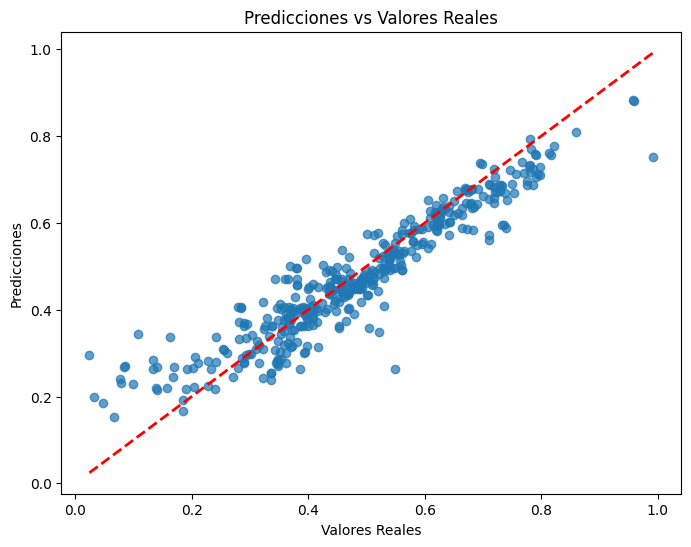

In [363]:
import matplotlib.pyplot as plt

# Predicciones vs Reales
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Línea de identidad
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.show()

## Uso del modelo

### Carga del modelo

In [369]:
import joblib

# Cargar el scaler previamente guardado
scaler = joblib.load('scaler.joblib')

In [374]:
# Verifica las dimensiones de X_test
print("Dimensiones de X_test:", X_test.shape)

# Asegúrate de que X_test tiene las mismas columnas que los datos originales usados para entrenar el scaler
# Si X_test es un DataFrame, asegúrate de que las columnas sean las correctas
# Si X_test no tiene el mismo número de columnas, esto causará el error

# Invertir la normalización de X_test (debe tener las mismas columnas que los datos originales)
X_original = scaler.inverse_transform(X_test)

# Verificar el resultado
print("Datos invertidos (X_original):", X_original)

Dimensiones de X_test: (409, 32)
Datos invertidos (X_original): [[3.45000000e+03 3.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [3.13887074e+03 2.94132993e+00 1.00532821e+00 ... 7.60136777e-01
  3.45834343e+00 1.00000000e+00]
 [5.64000000e+03 2.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.87140523e+03 1.91890068e+00 1.01272619e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [6.49257453e+03 2.96336682e+00 9.95604512e-01 ... 2.02072693e+00
  4.92644057e+00 4.00000000e+00]
 [6.32274374e+03 3.01828525e+00 9.25867849e-01 ... 1.26769927e+00
  2.74791661e+00 1.00000000e+00]]


In [ ]:
# Cargar el scaler
scaler = joblib.load('scaler.joblib')  # Asegúrate de que este archivo exista

# Hacer las predicciones sobre los datos de prueba
y_pred_scaled = model.predict(X_test)

# Invertir la transformación de las predicciones (volver a la escala original)
y_pred_original = scaler.inverse_transform(y_pred_scaled)

# Invertir la transformación de y_test (volver a la escala original)
y_test_original = scaler.inverse_transform(y_test.reshape)

# Calcular el error porcentual
error_percentage = np.abs((y_test_original - y_pred) / y_test_original) * 100

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Real Price': y_test_original,
    'Predicted Price': y_pred,
    'Error (%)': error_percentage.flatten()
})

# Mostrar las primeras filas de los resultados
print(results.head())